# Full pipeline with EO-ML and quantile regression forest

Given: Embeddings from e.g. SSL4EO-L

In this notebook, I try fitting a model "outside" the sampleing loop. This is more in line with how we would do in practice if we make a map.

In [1]:
import os
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, LeaveOneGroupOut, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

RANDOM_STATE = 42

In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_img_data.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
68070,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
68071,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
68072,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
68073,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


## Simulate treatment

Add embedding treatment

In [3]:
TRUE_ATE = 10

np.random.seed(RANDOM_STATE)
t = np.random.binomial(1, 0.2, len(df)) == 1 # Get as boolean

# Save treatment status and add treatment effect
df['treated'] = t
df.loc[t, 'iwi'] += np.random.normal(TRUE_ATE, 1, size=sum(t))

# Modify treated image embeddings
#w = np.random.normal(loc=1, scale=0.1, size=embeddings.shape[1])
#embeddings[t] *= w
embeddings[t, 0] += 0.1
df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,treated
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459,False
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,15.551803,True
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211,False
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697,False
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944,False
...,...,...,...,...,...,...,...,...,...,...,...
68070,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567,False
68071,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,49.599437,True
68072,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326,False
68073,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344,False


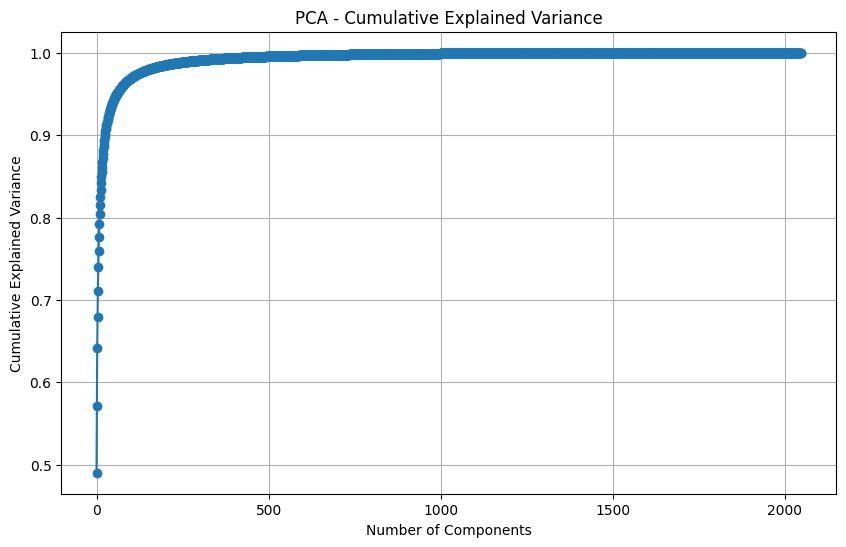

In [4]:
# Do full PCA
pca = PCA()
pca.fit(embeddings)

# Plot the cumulative explained variance to determine the optimal number of components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [5]:
# Choose the number of components required to capture 95% of the original variance
n_components = np.argmax(cumulative_variance > 0.95)
pca = PCA(n_components=n_components)
embeddings_reduced = pca.fit_transform(embeddings)

# 'embeddings_reduced' now contains the reduced feature set
print("Reduced embeddings shape:", embeddings_reduced.shape)

Reduced embeddings shape: (68075, 59)


In [6]:
X = embeddings_reduced
y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
t = df['treated'].values

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=.2, random_state=RANDOM_STATE)
X_train, X_cal, y_train, y_cal, t_train, t_cal = train_test_split(X_train, y_train, t_train, test_size=.25, random_state=RANDOM_STATE)

print('y_train:', y_train.shape)
print('y_cal:', y_cal.shape)
print('y_test:', y_test.shape)

y_train: (40845,)
y_cal: (13615,)
y_test: (13615,)


Fits a RandomForestQuantileRegressor, as this gives indivual CDFs for each point.

In [7]:
from quantile_forest import RandomForestQuantileRegressor

s0 = time()
qrf = RandomForestQuantileRegressor()
qrf.fit(X_train, y_train)
s1 = time()

print(f'Fitted a RF quantile regressor in {int(s1 - s0)} seconds')

Fitted a RF quantile regressor in 338 seconds


Calculate calibration deltas using calibration set

In [8]:
quantiles = list(np.linspace(0, 1, len(y_cal)))

preds = qrf.predict(X_cal, quantiles=quantiles)
deltas = []

for i, q in enumerate(quantiles):
    q_pred = preds[:, i]
    q_res = np.sort(y_cal - q_pred)
    q_delta = q_res[i] # np.quantile(q_res, q)
    deltas.append(q_delta)

deltas = np.asarray(deltas)

adjusted_preds = preds + deltas

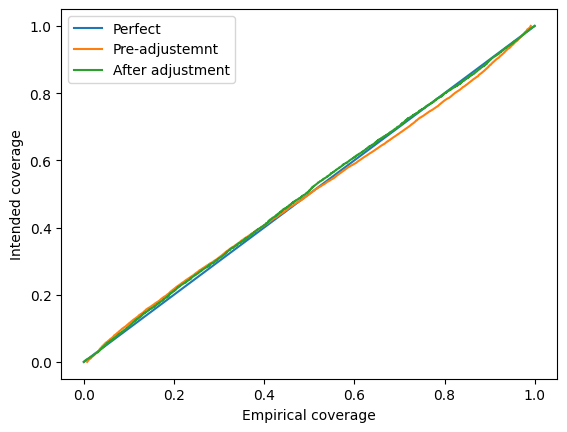

In [9]:
preds = qrf.predict(X_test, quantiles=quantiles)
adjusted_preds = preds + deltas

coverage = np.repeat(y_test[:, np.newaxis], len(quantiles), axis=1) < preds
adj_coverage = np.repeat(y_test[:, np.newaxis], len(quantiles), axis=1) < adjusted_preds
plt.plot(quantiles, quantiles, label='Perfect')
plt.plot(coverage.mean(axis=0), quantiles, label='Pre-adjustemnt')
plt.plot(adj_coverage.mean(axis=0), quantiles, label='After adjustment')
plt.xlabel('Empirical coverage')
plt.ylabel('Intended coverage')
plt.legend()
plt.show()

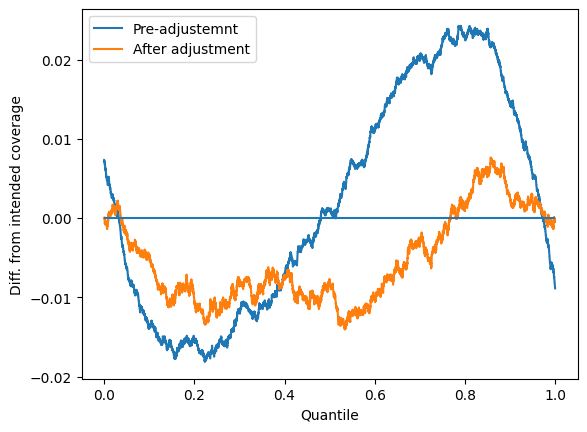

In [10]:
plt.plot(quantiles, coverage.mean(axis=0)-quantiles, label='Pre-adjustemnt')
plt.plot(quantiles, adj_coverage.mean(axis=0)-quantiles, label='After adjustment')
plt.hlines([0], 0, 1)
plt.xlabel('Quantile')
plt.ylabel('Diff. from intended coverage')
plt.legend()
plt.show()

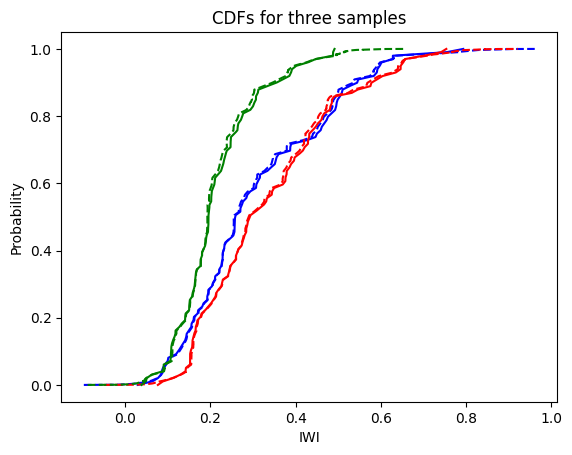

In [11]:
i = 0
plt.plot(preds[i], quantiles, 'b')
plt.plot(adjusted_preds[i], quantiles, 'b--')
plt.plot(preds[i+1], quantiles, 'r')
plt.plot(adjusted_preds[i+1], quantiles, 'r--')
plt.plot(preds[i+2], quantiles, 'g')
plt.plot(adjusted_preds[i+2], quantiles, 'g--')
plt.title('CDFs for three samples')
plt.ylabel('Probability')
plt.xlabel('IWI')
plt.show()

"Hit rate" for the different quantiles of the sampled CDF. Should be uniform but isn't?

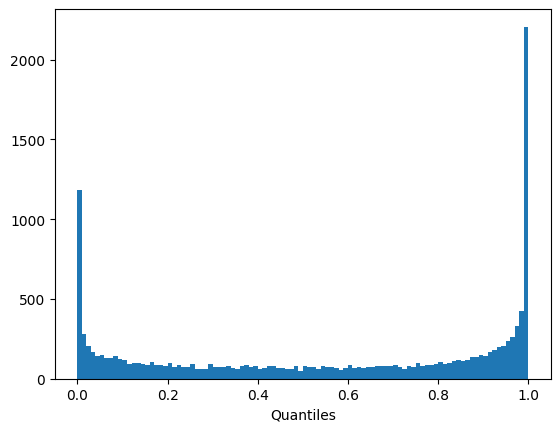

In [12]:
indices = np.array([np.searchsorted(row, y_i) for row, y_i in zip(preds, y)])
indices = indices / preds.shape[1]
plt.hist(indices, 100)
plt.xlabel('Quantiles')
plt.show()

Construct confidence intervals

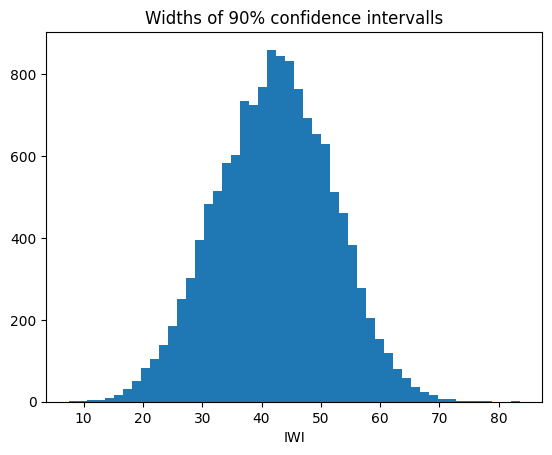

Mean interval width: 42.22
Median interval width: 42.39


In [13]:
q_05 = int(np.floor(len(quantiles) * 0.05))
q_95 = int(np.floor(len(quantiles) * 0.95))

widths = 100*(preds[:, q_95] - preds[:, q_05])
plt.hist(widths, 50)
plt.title('Widths of 90% confidence intervalls')
plt.xlabel('IWI')
plt.show()

print(f'Mean interval width: {np.mean(widths):.2f}')
print(f'Median interval width: {np.median(widths):.2f}')

In [14]:
emp_90_coverage = (preds[:, q_05] < y_test) & (y_test < preds[:, q_95])
print(f'Empirical coverage for 90% confidence intervals: {(100 * emp_90_coverage.mean()):.2f}%')

Empirical coverage for 90% confidence intervals: 91.18%


In [15]:
max_width = 30
emp_90_coverage = (preds[widths < max_width, q_05] < y_test[widths < max_width]) & (y_test[widths < max_width] < preds[widths < max_width, q_95])
print(f'Empirical coverage for 90% confidence intervals smaller than {max_width}: {(100 * emp_90_coverage.mean()):.2f}%')

Empirical coverage for 90% confidence intervals smaller than 30: 88.22%


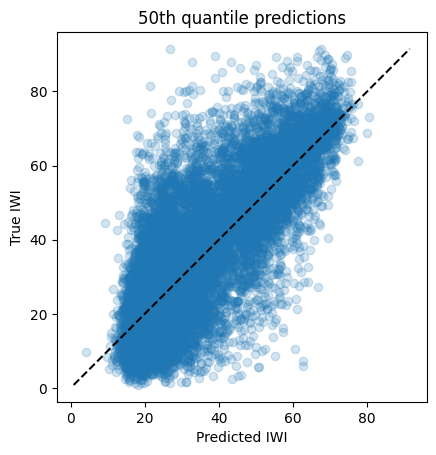

MSE: 148.50
MAE: 9.29
R^2: 0.61


In [16]:
q_50 = int(np.floor(len(quantiles) * 0.5))
point_preds = preds[:, q_50]

plt.scatter(100*point_preds, 100*y_test, alpha=0.2)
plt.plot([min(100*y_test), max(100*y_test)],[min(100*y_test), max(100*y_test)], 'k--')
plt.title('50th quantile predictions')
plt.xlabel('Predicted IWI')
plt.ylabel('True IWI')
plt.axis('scaled')
plt.show()

print(f'MSE: {mean_squared_error(100*y_test, 100*point_preds):.2f}')
print(f'MAE: {mean_absolute_error(100*y_test, 100*point_preds):.2f}')
print(f'R^2: {r2_score(y_test, point_preds):.2f}')

In [18]:
print(f'Treatred MSE: {mean_squared_error(100*y_test[t_test], 100*point_preds[t_test]):.2f}')
print(f'Treatred MAE: {mean_absolute_error(100*y_test[t_test], 100*point_preds[t_test]):.2f}')
print(f'Treatred R^2: {r2_score(y_test[t_test], point_preds[t_test]):.2f}')
print(f'Treatred mean residual: {np.mean(100*point_preds[t_test] - 100*y_test[t_test]):.2f}')
print('')
print(f'Control MSE: {mean_squared_error(100*y_test[~t_test], 100*point_preds[~t_test]):.2f}')
print(f'Control MAE: {mean_absolute_error(100*y_test[~t_test], 100*point_preds[~t_test]):.2f}')
print(f'Control R^2: {r2_score(y_test[~t_test], point_preds[~t_test]):.2f}')
print(f'Control mean residual: {np.mean(100*point_preds[~t_test] - 100*y_test[~t_test]):.2f}')

Treatred MSE: 209.42
Treatred MAE: 11.16
Treatred R^2: 0.43
Treatred mean residual: -8.84

Control MSE: 133.14
Control MAE: 8.82
Control R^2: 0.63
Control mean residual: 0.99


## Try in loop

In [22]:
from sklearn.utils import resample
from tqdm import tqdm

n_boots = 1000
n_cdf_rounds = 1000

ate_estimates = []

# Make predictions for all test samples.
# This is done outside of the loop to save on compute
y_pred = qrf.predict(X_test, quantiles=quantiles)
y_pred = y_pred + deltas # Add calibration deltas

for i in tqdm(range(n_boots)):
    # Sample with replacement
    y_pred_sample, t_sample = resample(y_pred, t_test, random_state=i)
    
    sample_ate_estimates = []
    n_samples, n_quantiles = y_pred_sample.shape
    
    for j in range(n_cdf_rounds):
        # Draw random quantiles to sample from for each predicted CDF
        indices = np.random.randint(0, n_quantiles, n_samples)
        draw_y_preds = y_pred_sample[np.arange(n_samples), indices]
        
        # No confounders, so just diff
        ate_estimate = np.mean(draw_y_preds[t_sample]) - np.mean(draw_y_preds[~t_sample])
        sample_ate_estimates.append(ate_estimate)
        
    ate_estimates.append(sample_ate_estimates)

# Save as a dataframe for easier plotting
res_df = pd.DataFrame(ate_estimates).reset_index().melt(id_vars='index')
res_df.columns = ['Boot', 'CDF round', 'ATE estimate']

100%|██████████| 1000/1000 [12:13<00:00,  1.36it/s]


In [23]:
# Rescale to IWI
res_df['ATE estimate'] *= 100
res_df

,Boot,CDF round,ATE estimate
0,0,0,-0.086360
1,1,0,0.186501
2,2,0,-0.867793
3,3,0,-0.841298
4,4,0,-0.044797
...,...,...,...
999995,995,999,-0.564226
999996,996,999,-0.612234
999997,997,999,0.054899
999998,998,999,0.140577


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


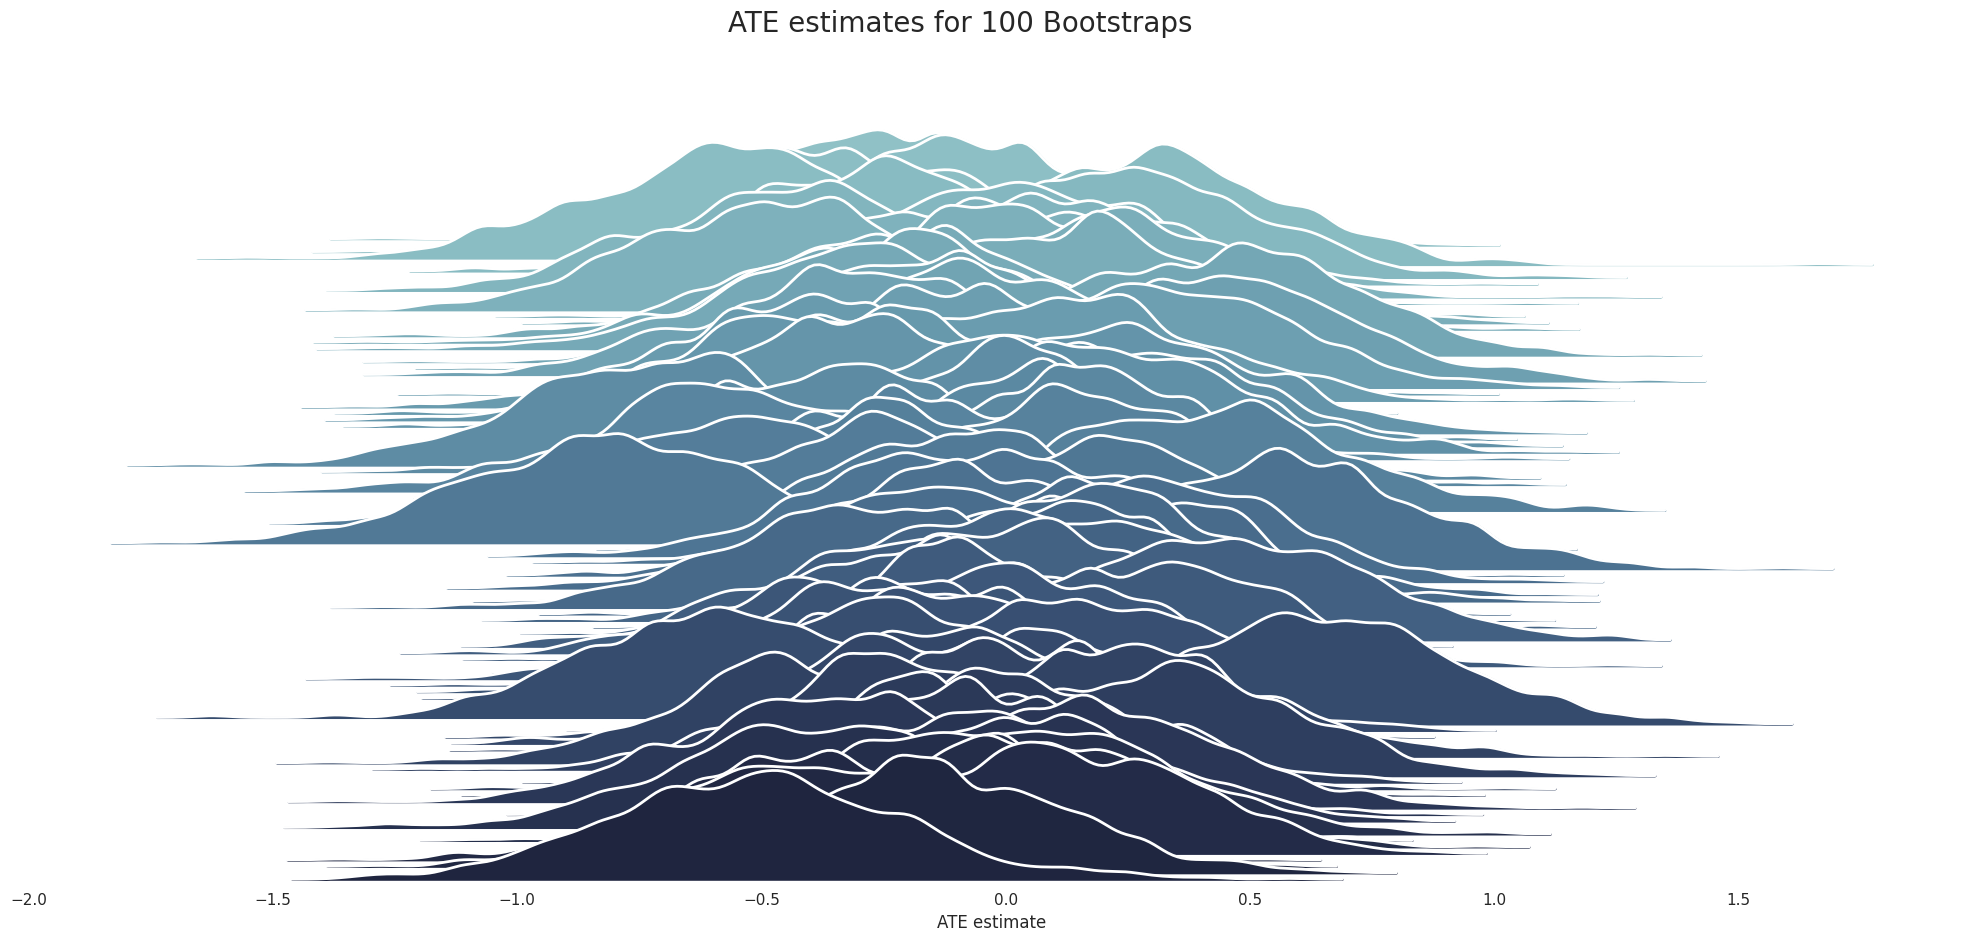

In [24]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(100, rot=-.25, light=.7)
g = sns.FacetGrid(
    res_df[res_df['Boot'] < 100], row='Boot', hue='Boot', aspect=250, height=0.1, palette=pal
)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'ATE estimate',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "ATE estimate", clip_on=False, color='w', lw=2, bw_adjust=.5)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.95)

# Remove axes details that don't play well with overlap
g.set_titles('')
g.set(yticks=[], ylabel='')
g.despine(bottom=True, left=True)

plt.suptitle('ATE estimates for 100 Bootstraps', fontsize=20)
plt.show()

In [25]:
def calculate_errors_from_df(df):
    
    # Calculate variance of ATE estimates within each bootstrap sample (for modeling error)
    grouped = df.groupby('Boot')['ATE estimate']
    row_variances = grouped.var()  # Variance within each bootstrap sample
    modeling_error = np.sqrt(row_variances.mean())  # Average variance and take sqrt
    
    # Calculate mean of ATE estimates for each bootstrap sample (for sampling error)
    row_means = grouped.mean()  # Mean for each bootstrap sample
    sampling_error = np.sqrt(row_means.var(ddof=1))  # Variance of the means and take sqrt
    
    return modeling_error, sampling_error

modeling_error, sampling_error = calculate_errors_from_df(res_df)

global_mean = res_df['ATE estimate'].mean()
z = norm.ppf(0.975)

# Confidence Interval using Sampling Error only
ci_sampling_only = (global_mean - z * sampling_error, global_mean + z * sampling_error)

# Total error combining modeling and sampling errors
total_error = np.sqrt(sampling_error**2 + modeling_error**2)

# Confidence Interval using both errors
ci_with_both_errors = (global_mean - z * total_error, global_mean + z * total_error)

print('Mean estimated ATE:', global_mean)
print('Sampling error:', sampling_error)
print('Modeling error:', modeling_error)
print('95% Confidence interval with just sampling error:', ci_sampling_only)
print('95% Confidence interval with both model and sampling error:', ci_with_both_errors)

Mean estimated ATE: -0.10823136115384943
Sampling error: 0.30487030995625264
Modeling error: 0.28831995847138037
95% Confidence interval with just sampling error: (-0.7057661886236677, 0.48930346631596877)
95% Confidence interval with both model and sampling error: (-0.930655940994823, 0.714193218687124)


The treatment effect is completely missed because we over-estimate the control points and under-estimate the treated points